# Procesamiento Digital de Imágenes Satelitales
# Instituto Gulich - Mayo a Julio 2025

---
#  Clase 07a: Clasificación Supervisada aplicada a imágenes satelitales
---

En esta Notebook aplicaremos las herramientas aprendidas en la Clase 06 para extraer y etiquetar nuestras muestras, e implementar los clasificadores supervisados vistos en la teoría.

Importamos las bilbiotecas que usaremos:

```python
# Bibliotecas de Python
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Importación de funciones propias
import sys
sys.path.append('../')
from funciones import *

# Scikit-learn
from sklearn import datasets, metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score as kappa
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
```

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Importación de funciones propias

from funciones import *

# Scikit-learn
from sklearn import datasets, metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score as kappa
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Generación de los conjuntos X e Y

Vamos a empezar por definir nuestras rutas de trabajo y leer un archivo GEOJSON que contiene los vectores a partir de los cuales construiremos nuestros datos etiquetados. También leeremos la imagen para conocer que cantidad de bandas tiene: Este será nuestro número de atributos, almacenados en una variable _d_: 

```python
#Levanto en X, Y los datos etiquetados, como antes

#Datos del raster y del shp
path_proc = '../data/proc/'
path_out = '../data/out/'
path_shp = '../data/raw_data/vector/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
rois_shp = gpd.read_file(path_shp+'rois_dique3.geojson')

#Leo los ROIS
with rasterio.open(raster_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster
    m=src.read()

nodata=-255 #elijo un valor raro para nodata
```

In [2]:
#Levanto en X, Y los datos etiquetados, como antes

#Datos del raster y del shp
path_proc = './proc/'
path_out = './out/'
path_shp = './raw_data/vector/'
raster_fn = path_proc + 'S2_dique_20181006.tif'
rois_shp = gpd.read_file(path_shp+'rois_dique3.geojson')

#Leo los ROIS
with rasterio.open(raster_fn) as src:
    d=src.count #cantidad de atributos = cantidad de bandas en el raster
    m=src.read()

nodata=-255 #elijo un valor raro para nodata

C:\Python39\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: Several features with id = 3 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


Con la función _nequalize_ de nuestro archivo de funciones, más _show_ de Rasterio podemos visualizar las bandas en RGB:

```python
plt.figure(figsize=(10,10))
show(nequalize(m)[[2,1,0]])
plt.show()
```

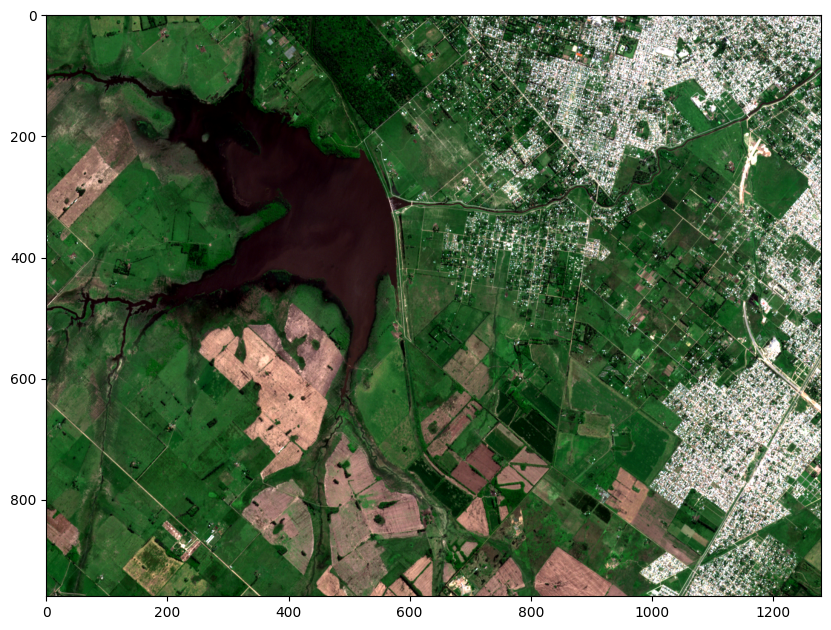

In [3]:
plt.figure(figsize=(10,10))
show(nequalize(m)[[2,1,0]])
plt.show()

Armamos un dicccionario donde la clave sea el valor de la clase, y el valor sea el código numérico que le asignamos:

```python
clases=list(set(rois_shp['clase']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}

print(clase_dict)
```

In [4]:
clases=list(set(rois_shp['clase']))
clases.sort() #numero las clases de los ROIs alfabéticamente
clase_dict = {clase:i for i, clase in enumerate(clases)}

print(clase_dict)

{'agua': 0, 'bosque': 1, 'humedal': 2, 'rural_cultivo': 3, 'rural_sd': 4, 'urbano': 5}


Creamos nuestros arreglos de _numpy_ donde almacenaremos nuestros atributos (X) y sus etiquetas, las clases (Y). Empiezan teniendo 0 datos, y los iremos rellenando usando nuestras ROIs:

```python
#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas
```

In [5]:
#Preparo colección de atributos etiquetados. Comienza con 0 datos
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

X se inicializa con 5 columnas, ya que recibirá información de nuestras 5 bandas. Y en cambio es unidimensional, ya que solo contene las etiquetas (Clases):

```python
print(X.shape)
print(Y.shape)
```

In [6]:
print(X.shape)
print(Y.shape)

(0, 5)
(0,)


A continuación, abrimos la imagen como objeto de rasterio (**src**), y vamos a ir recorriendo cada uno de los polígonos de nuestras ROI con un método de Pandas que se llama **iterrows()**. Repasemos primero cómo funciona eso:

```python
for index, row in rois_shp.iterrows():
    print(f'Valor de la clase para el elemento {index}:', row['clase'])
```

In [7]:
for index, row in rois_shp.iterrows():
    print(f'Valor de la clase para el elemento {index}:', row['clase'])

Valor de la clase para el elemento 0: humedal
Valor de la clase para el elemento 1: agua
Valor de la clase para el elemento 2: bosque
Valor de la clase para el elemento 3: urbano
Valor de la clase para el elemento 4: rural_cultivo
Valor de la clase para el elemento 5: rural_cultivo
Valor de la clase para el elemento 6: urbano
Valor de la clase para el elemento 7: humedal
Valor de la clase para el elemento 8: humedal
Valor de la clase para el elemento 9: humedal
Valor de la clase para el elemento 10: humedal
Valor de la clase para el elemento 11: rural_sd
Valor de la clase para el elemento 12: rural_sd
Valor de la clase para el elemento 13: rural_cultivo
Valor de la clase para el elemento 14: bosque
Valor de la clase para el elemento 15: bosque
Valor de la clase para el elemento 16: rural_sd
Valor de la clase para el elemento 17: humedal
Valor de la clase para el elemento 18: rural_sd
Valor de la clase para el elemento 19: humedal
Valor de la clase para el elemento 20: humedal


Vamor a aprovechar el _iterrows()_ para ir obteniendo la geometría y la clase de cada polígono, usar esa geometría para enmascarar nuestro raster, y luego re-acomodar los datos a la estructura de X para poder cargarlos:

```python
with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        poli = row['geometry']
        clase = row['clase']
        #Realizo la máscara usando poli como geometria
        clip, _transform = mask(src, [poli], crop=True,nodata=nodata)
        #Calculo las dimensiones del recorte (d siempre va a ser igual, numero de bandas)
        d,x,y = clip.shape
        # Reacomodo todo como si fuera una tabla (reshape), y con .T lo traspongo. Eso me da la 
        #misma estructura de X
        D = list(clip.reshape([d,x*y]).T)
        #Con esta línea me aseguro de eliminar cualquier valor NoData producto del enmascarado. Usamos .prod() para
        # garantizar que en nunguna dimensión (banda) haya quedado un valor sin datos
        D = [p for p in D if (not (p==nodata).prod())]
        # Convierto a la tabla/lista D en array
        DX = np.array(D)
        #Genero la lista de etiquetas (número) que corresponden a esta clase (lo saco del diccionario definido previamente)
        DY = np.repeat(clase_dict[clase],len(D))
        #a X le concateno DX
        X = np.concatenate((X,DX))
        #a Y le concateno DY
        Y = np.concatenate((Y,DY))
```

In [8]:
with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        poli = row['geometry']
        clase = row['clase']
        #Realizo la máscara usando poli como geometria
        clip, _transform = mask(src, [poli], crop=True,nodata=nodata)
        #Calculo las dimensiones del recorte (d siempre va a ser igual, numero de bandas)
        d,x,y = clip.shape
        # Reacomodo todo como si fuera una tabla (reshape), y con .T lo traspongo. Eso me da la 
        #misma estructura de X
        D = list(clip.reshape([d,x*y]).T)
        #Con esta línea me aseguro de eliminar cualquier valor NoData producto del enmascarado. Usamos .prod() para
        # garantizar que en nunguna dimensión (banda) haya quedado un valor sin datos
        D = [p for p in D if (not (p==nodata).prod())]
        # Convierto a la tabla/lista D en array
        DX = np.array(D)
        #Genero la lista de etiquetas (número) que corresponden a esta clase (lo saco del diccionario definido previamente)
        DY = np.repeat(clase_dict[clase],len(D))
        #a X le concateno DX
        X = np.concatenate((X,DX))
        #a Y le concateno DY
        Y = np.concatenate((Y,DY))

Luego de correr este bloque, tendré dos arreglos de Numpy con 54959 filas (cada una corresponde a un pixel). En el caso de X, tendré además 5 columnas, cada una representando el valor de las 5 bandas para esos píxeles.

```python
print(X.shape)
print(Y.shape)
```

In [9]:
print(X.shape)
print(Y.shape)

(54959, 5)
(54959,)


Si queremos ver cuántos píxeles tengo para cada una de mis clases, puedo crear un diciconario que los contabilice e imprimir sus contenidos:

```python
L = list(Y)
E = set(L) #set devuelve valores únicos

print(f'valores únicos de clases (números): {E}')
  
pixels_por_clase = {clases[y]:L.count(y) for y in E}

for clase in clases:
    print(f"{clase:>15s}: {pixels_por_clase[clase]}")
```

In [10]:
L = list(Y)
E = set(L) #set devuelve valores únicos

print(f'valores únicos de clases (números): {E}')
  
pixels_por_clase = {clases[y]:L.count(y) for y in E}

for clase in clases:
    print(f"{clase:>15s}: {pixels_por_clase[clase]}")

valores únicos de clases (números): {0, 1, 2, 3, 4, 5}
           agua: 11531
         bosque: 12434
        humedal: 6676
  rural_cultivo: 11004
       rural_sd: 7884
         urbano: 5430


Finalmente, separemos los datos en entrenamiento y validación para una mejor evaluación de los modelos. Usaremos el módulo `train_test_split`  que ya importamos anteriormente. Usamos `random_state` para asegurar que siempre re realiza la misma partición:

```python
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42) # 75% para train y 25% para test
```

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42) # 75% para train y 25% para test

## Un primer modelo: KNN

### Explicación del modelo de KNN. 

Dada una observación nueva, consideramos las `K` muestras etiquetadas más cercanas (`NN`) en el espacio de atributos. La clase asignada a esta nueva observación será la mayoritaria en el conjunto de vecinas.

En Scikit-Learn, en general: 

- [x] Definimos primero al clasificador con sus hiperparámetros llamando al módulo específico (en este caso _KNeighborsClassifier_), que lo importamos más arriba.
- [x] Entrenamos el modelos con el método _.fit()_, pasándole como argumentos nuestro X y nuestro Y
- [x] Una vez entrenado e modelo, lo usamos para predecir sobre nuestros datos originales (X).

Empecemos entrenando con un solo vecino (`n_neighbors = 1`)

¿Qué esperan que pase con esta configuración?

```python
model = KNeighborsClassifier(n_neighbors = 1) # modelo en abstracto
model.fit(X_train, Y_train) # entreno el modelo con los datos X e Y de entrenamiento
Y_pred = model.predict(X_test) # me fijo qué clases les asigna el modelo a mis datos
```

In [12]:
model = KNeighborsClassifier(n_neighbors = 1) # modelo en abstracto
model.fit(X_train, Y_train) # entreno el modelo con los datos X e Y de entrenamiento
Y_pred = model.predict(X_test) # me fijo qué clases les asigna el modelo a mis datos

------------------

### ¿Cómo evaluamos nuestro clasificador?

#### Matriz de confusión.

Para cada clase i, nos fijamos cuántas observaciones de la clase fueron clasificadas en cada clase j. Esto nos da una matriz cuadrada, con una fila y columna por cada clase.

```python
metrics.confusion_matrix(Y_test, Y_pred)
```

In [13]:
metrics.confusion_matrix(Y_test, Y_pred)

array([[2931,    0,    1,    0,    0,    0],
       [   0, 2821,  226,   16,    0,    0],
       [   0,  196, 1199,  268,    0,    3],
       [   0,   10,  258, 2503,    1,    4],
       [   0,    0,    0,    1, 1974,    3],
       [   0,    0,    7,   17,   21, 1280]], dtype=int64)

Usando la función `ConfusionMatrixDisplay` podemos visualizar más claramente esta matriz, con los nombres correspondientes de las clases:

```python
from sklearn.metrics import ConfusionMatrixDisplay

# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()
```

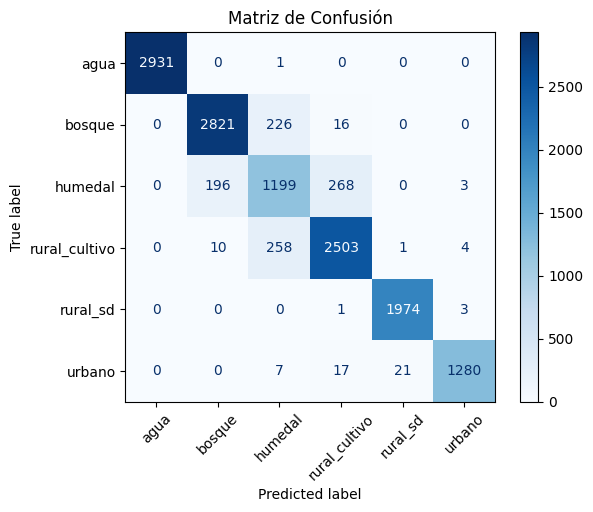

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

#### Exactitud o _accuracy_

Es una medida numérica que cuenta la proporción de observaciones bien clasificadas. Es decir: 
cantidad de observaciones bien clasificadas / cantidad total de observaciones. Entrenar un KNN con `n_neighbors = 1` nos da un ajuste perfecto para nuestro conjunto de entrenamiento, con lo cual estamos _sobre-ajustando_:

```python
print("Exactitud del modelo:", metrics.accuracy_score(Y_test, Y_pred))
```

In [15]:
print("Exactitud del modelo:", metrics.accuracy_score(Y_test, Y_pred))

Exactitud del modelo: 0.9248908296943231


#### Índice Kappa

Una medida de exactitud para clases desbalanceadas. 
El Coeficiente kappa de Cohen es una medida estadística de la exactitud de una clasificación que tiene en cuenta el desbalance entre la cantidad de elementos de las diferentes categorías. Es considreada una medida más robusta que el simple cálculo de la exactitud.

Por ejemplo: Tenemos datos reales (entrenamiento) están compuestos por un vector de 100 elementos donde todos los valores son 0, salvo el primero que es 1. Nuestras predicción sobre los mismos es un vector donde todos los elementos son 0.

El _acccuracy_ daría muy alto, ya que solamente le habríamos "errado" a una predicción. El Coeficiente Kappa, en cambio, daría 0, ya que la predicción "se equivocó" en todos los valores de clase 1:

```python
ceros = np.zeros(100)
un_uno = ceros.copy()
un_uno[0] = 1
otro_uno = ceros.copy()
otro_uno[1] = 1

print(un_uno)
print(ceros)


acc = accuracy_score(un_uno, ceros)
print(f'accuracy: {acc:.3f}')

k = kappa(un_uno, ceros)
print(f'kappa index: {k:.3f}')
```

In [16]:
ceros = np.zeros(100)
un_uno = ceros.copy()
un_uno[0] = 1
otro_uno = ceros.copy()
otro_uno[1] = 1

print(un_uno)
print(ceros)


acc = accuracy_score(un_uno, ceros)
print(f'accuracy: {acc:.3f}')

k = kappa(un_uno, ceros)
print(f'kappa index: {k:.3f}')

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
accuracy: 0.990
kappa index: 0.000


Veamos cómo da el Kappa con nuestro primer casificador:

```python
k = kappa(Y_test, Y_pred)
print(f'kappa index: {k:.3f}')
```

In [17]:
k = kappa(Y_test, Y_pred)
print(f'kappa index: {k:.3f}')

kappa index: 0.908


### Validación cruzada

En este modelo de KNN, al igual que en muchos otros, hay un parámetro (en este caso n_neighbors) que le da al modelo mayor capacidad de adaptarse a las irregularidades o variabiliad de los datos. Cuando un modelo se adapta _demasiado_ a las variaciones de los datos, se da un _overfitting_. 

Para prevenir este fenómeno, podemos hacer cross-validation. Consiste en repetir muchas veces el experimento de separar los datos en train y test (como recién) y evaluar la predicción para cada valor de el/los parámetros. Luego promediamos y vemos cómo fue el desempeño promedio para cada elección del/los parámetros.

### K-folding
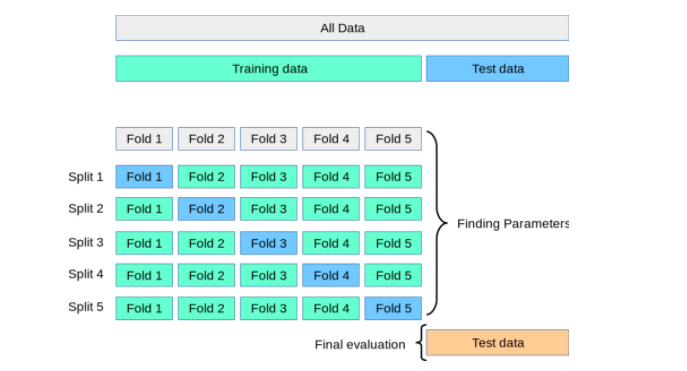


En ScikitLearn utilizamos el K-folding pero estratificado. Esto es para poder respetar dentro de cada sub-grupo la proporción de cada clase en el conjunto original:

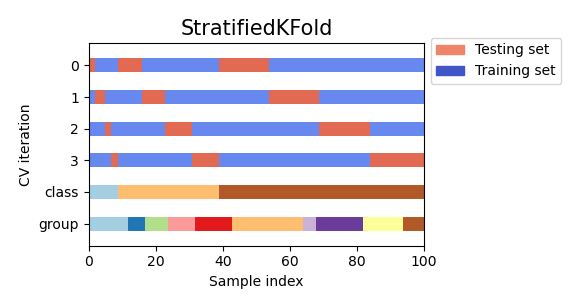

El K-fold en Scikit-Learn se llama _[StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)_ y su principal parámetro es el número de divisiones (`n_splits`). Con el parámetro `random_state` podríamos fijar una semilla para obtener siempre las mismas particiones:

```python
n_splits = 5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 42)
print(skf)
```

In [18]:
n_splits = 5
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 42)
print(skf)

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


El siguiente bloque de codigo realiza lo siguiente:

- A partir del método *split()* aplicado sobre el objeto *skf* creado en la celda anterior (es un generador) podemos pedir los índices de los elementos que conforman los conjuntos de train y test en cada _fold_. Observar que reicen aquí estamos aplicando el StratifiedKfold sobre X e Y. Los índices se refieren a las posiciones de cada uno de los elementos en el conjunto de datos original (el completo):

```python
for train_index, test_index in skf.split(X,Y):
    print('Índices para los conjuntos de entrenamiento: ', train_index)
    print('Índices para los conjuntos de test: ', test_index)
```

In [19]:
for train_index, test_index in skf.split(X,Y):
    print('Índices para los conjuntos de entrenamiento: ', train_index)
    print('Índices para los conjuntos de test: ', test_index)

Índices para los conjuntos de entrenamiento:  [    0     1     2 ... 54955 54956 54957]
Índices para los conjuntos de test:  [    6    18    25 ... 54942 54950 54958]
Índices para los conjuntos de entrenamiento:  [    1     2     5 ... 54956 54957 54958]
Índices para los conjuntos de test:  [    0     3     4 ... 54937 54939 54941]
Índices para los conjuntos de entrenamiento:  [    0     1     2 ... 54956 54957 54958]
Índices para los conjuntos de test:  [    9    10    17 ... 54945 54953 54954]
Índices para los conjuntos de entrenamiento:  [    0     1     3 ... 54954 54957 54958]
Índices para los conjuntos de test:  [    2    13    14 ... 54949 54955 54956]
Índices para los conjuntos de entrenamiento:  [    0     2     3 ... 54955 54956 54958]
Índices para los conjuntos de test:  [    1     5    12 ... 54951 54952 54957]


Lo que hace la siguiente celda es aprovechar esos indices para ir iterando sobre ellos y, en cada iteración, correr y validar el modelo para el conjunto de entrenamiento (`X[train_index,:]`) y de test (`X[test_index,:]`) de cada _fold_. Los resultados de _accuracy_ de esta corrida se van guardando en dos array distintos: Uno para _train_ (`resultados_train`) y otro para _test_ (`resultados_test`). A su vez, para cada fold o sub-conjunto, se probará el modelo KNN con `n_neighbors` de 1 a 15 (esto lo regulamos con la variable `valores_K`).

Estas matrices tendrán una dimensión de 5 x 15. La primer dimensión se refiere a la cantidad de _Folds_ o sub-conjuntos, y la segunda a cada una de las 15 pruebas que haremos variando el valor de `n_neighbors`.

Al inicio del bucle _for_ incorporamos un contador al que llamaremos _split_. Esto es para que al almacenar los resultados de _accuracy_ en las matries correspondientes, Python sepa a qué fold (primera dimensión) corresponde la corrida en curso. Al final de cada ciclo, aumentamos en 1 el valor de _split_ (`split += 1`):

```python
valores_K = range(1, 16)

resultados_train = np.zeros((n_splits, len(valores_K)))
resultados_test = np.zeros((n_splits, len(valores_K)))

split = 0
for train_index, test_index in skf.split(X,Y):
    print('Número de fold: ',split)
    X_train_split, X_test_split = X[train_index,:], X[test_index,:]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]    
    for k in valores_K:
        print('Probando con n_neighbors = ', k)
        model = KNeighborsClassifier(n_neighbors = k) # Acá lo que va variando es el valor k
        model.fit(X_train_split, Y_train_split) 
        Y_pred_split = model.predict(X_test_split)
        Y_pred_train_split = model.predict(X_train_split)
        acc_test = metrics.accuracy_score(Y_test_split, Y_pred_split)
        acc_train = metrics.accuracy_score(Y_train_split, Y_pred_train_split)
        resultados_test[split, k-1] = acc_test
        resultados_train[split, k-1] = acc_train
    split += 1 #Aumento en 1 el contador
```

In [20]:
valores_K = range(1, 16)

resultados_train = np.zeros((n_splits, len(valores_K)))
resultados_test = np.zeros((n_splits, len(valores_K)))

split = 0
for train_index, test_index in skf.split(X,Y):
    print('Número de fold: ',split)
    X_train_split, X_test_split = X[train_index,:], X[test_index,:]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]    
    for k in valores_K:
        print('Probando con n_neighbors = ', k)
        model = KNeighborsClassifier(n_neighbors = k) # Acá lo que va variando es el valor k
        model.fit(X_train_split, Y_train_split) 
        Y_pred_split = model.predict(X_test_split)
        Y_pred_train_split = model.predict(X_train_split)
        acc_test = metrics.accuracy_score(Y_test_split, Y_pred_split)
        acc_train = metrics.accuracy_score(Y_train_split, Y_pred_train_split)
        resultados_test[split, k-1] = acc_test
        resultados_train[split, k-1] = acc_train
    split += 1 #Aumento en 1 el contador

Número de fold:  0
Probando con n_neighbors =  1
Probando con n_neighbors =  2
Probando con n_neighbors =  3
Probando con n_neighbors =  4
Probando con n_neighbors =  5
Probando con n_neighbors =  6
Probando con n_neighbors =  7
Probando con n_neighbors =  8
Probando con n_neighbors =  9
Probando con n_neighbors =  10
Probando con n_neighbors =  11
Probando con n_neighbors =  12
Probando con n_neighbors =  13
Probando con n_neighbors =  14
Probando con n_neighbors =  15
Número de fold:  1
Probando con n_neighbors =  1
Probando con n_neighbors =  2
Probando con n_neighbors =  3
Probando con n_neighbors =  4
Probando con n_neighbors =  5
Probando con n_neighbors =  6
Probando con n_neighbors =  7
Probando con n_neighbors =  8
Probando con n_neighbors =  9
Probando con n_neighbors =  10
Probando con n_neighbors =  11
Probando con n_neighbors =  12
Probando con n_neighbors =  13
Probando con n_neighbors =  14
Probando con n_neighbors =  15
Número de fold:  2
Probando con n_neighbors =  1
P

A nosotros nos interesa tener alguna medida resumen de cómo impactó la variación de `n_neighbors` en el _accuracy_ de nuestros conjuntos de train y test. Lo podríamos conservar para posteriores análisis, pero aquí lo simplificaremos. Una manera posible es calcular la media de todos los _folds_ para cada `n_neighbor`:

```python
promedios_train = np.mean(resultados_train, axis = 0) 
promedios_test = np.mean(resultados_test, axis = 0)
```

In [21]:
promedios_train = np.mean(resultados_train, axis = 0) 
promedios_test = np.mean(resultados_test, axis = 0)

Entonces ahora pasamos a tener vectores resumen con una longitud equivalente a `n_splits`:

```python
print(promedios_train.shape)
print(promedios_test.shape)
```

In [22]:
print(promedios_train.shape)
print(promedios_test.shape)

(15,)
(15,)


Teniéndolos así, los podemos plotear para hacer un análisis del impacto de los K vecinos:

```python
plt.plot(valores_K, promedios_train, label = 'Train')
plt.plot(valores_K, promedios_test, label = 'Test')
plt.legend()
plt.title('Exactitud del modelo de KNN')
plt.xlabel('K vecinos')
plt.ylabel('Exactitud (accuracy)')
plt.show()
```

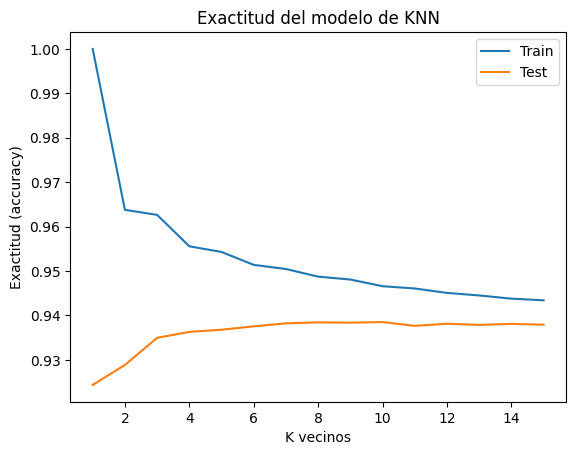

In [23]:
plt.plot(valores_K, promedios_train, label = 'Train')
plt.plot(valores_K, promedios_test, label = 'Test')
plt.legend()
plt.title('Exactitud del modelo de KNN')
plt.xlabel('K vecinos')
plt.ylabel('Exactitud (accuracy)')
plt.show()

Hacer este tipo de corridas es muy interesante para ver como `n_neighbors` provoca un sobre-ajuste en el conjunto de entrenamiento. Pareciera ser que el valor de exactitud se estabiliza a partir de cierta cantidad de K-vecinos (observar como usamos _argmax_ para obtener la posición correspondiente al máximo):

```python
#Índice de la posición con el valor máximo de accuracy:
ind_max = np.argmax(promedios_test)
mejor_k = valores_K[ind_max]

print('Valor de accuracy de test máximo: ',promedios_test[ind_max])
print(f'El mejor valor de accuracy se logró con {mejor_k} vecinos')
```


In [24]:
#Índice de la posición con el valor máximo de accuracy:
ind_max = np.argmax(promedios_test)
mejor_k = valores_K[ind_max]

print('Valor de accuracy de test máximo: ',promedios_test[ind_max])
print(f'El mejor valor de accuracy se logró con {mejor_k} vecinos')

Valor de accuracy de test máximo:  0.9384995921633381
El mejor valor de accuracy se logró con 10 vecinos


## Árboles de decisión (Decision Trees)


Instanciamos el clasificador usando esta vez _DecisionTreeClassifier_, sin especificar su máxima profundidad (`max_depth`). También le decimos que el criterio para maximizar la ganancia de información sea la entropía (`criterion = 'entropy'`), ya que por defecto usa el coeficiente de Gini. Para mantener la reproducibilidad del resultado,  fijamos como semilla (`random_state`) el valor 42:

```python
#Armamos y entrenamos un *Decision tree*
from sklearn import tree

#Cuando no especificamos el max_depth, el árbol no tiene límite en la profundidad:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
``` 

In [25]:
#Armamos y entrenamos un *Decision tree*
from sklearn import tree

#Cuando no especificamos el max_depth, el árbol no tiene límite en la profundidad:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42)
clf = clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

Calculamos las métricas Kappa y Accuracy, e imprimimos la matriz de confusión:

```python
# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Accuracy y Kappa
acc = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc:.2f}')

k = kappa(Y_test, Y_pred)
print(f'Índice Kappa: {k:.2f}')
```

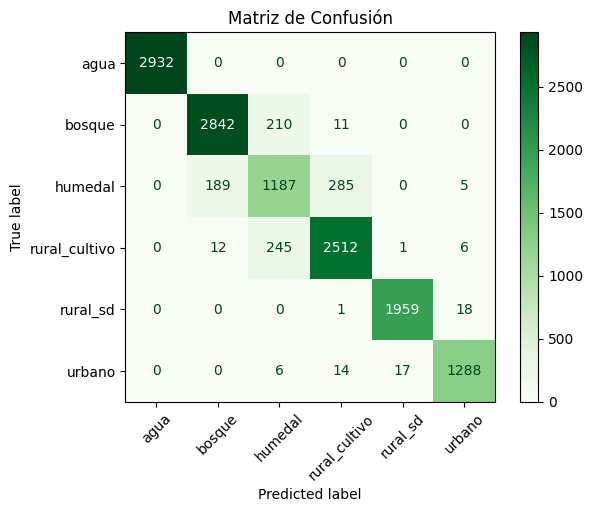

Accuracy: 0.93
Índice Kappa: 0.91


In [26]:
# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Accuracy y Kappa
acc = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc:.2f}')

k = kappa(Y_test, Y_pred)
print(f'Índice Kappa: {k:.2f}')

### Selección de profundidad

A continuación analizaremos cuál es el efecto del parámetro de profundidad o `max_depth`, usando K-folding con `n_splits = 5` al igual que con KNN. Sin embargo, aquí probaremos una gama de valores de profundidad más amplia (de 2 a 24), con lo cual este proceso probablemente lleve más tiempo en correr. Re-utilizaremos el K-Fold que utilizamos para KNN, el cual guardamos en la variable `skf`.

```python
lmd = np.arange(2,25)
resultados_test_DT = np.zeros([n_splits,len(lmd)])
resultados_train_DT = np.zeros([n_splits,len(lmd)])
conf_m_list = []

split = 0
for train_index, test_index in skf.split(X, Y):
    print(f'Número de fold: {split}')
    X_train_split, X_test_split = X[train_index, :], X[test_index, :]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]
    for md_idx, md in enumerate(lmd):
        #print(f'  Probando con max_depth = {md}')
        clf = tree.DecisionTreeClassifier(max_depth=md, random_state = 42)
        clf.fit(X_train_split, Y_train_split)
        Y_pred_test_split  = clf.predict(X_test_split)
        Y_pred_train_split = clf.predict(X_train_split)
        resultados_test_DT[split, md_idx]  = metrics.accuracy_score(Y_test_split,  Y_pred_test_split)
        resultados_train_DT[split, md_idx] = metrics.accuracy_score(Y_train_split, Y_pred_train_split)
        conf_m_list.append(confusion_matrix(Y_test_split,  Y_pred_test_split))
    split += 1
```

In [27]:
lmd = np.arange(2,25)
resultados_test_DT = np.zeros([n_splits,len(lmd)])
resultados_train_DT = np.zeros([n_splits,len(lmd)])
conf_m_list = []

split = 0
for train_index, test_index in skf.split(X, Y):
    print(f'Número de fold: {split}')
    X_train_split, X_test_split = X[train_index, :], X[test_index, :]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]
    for md_idx, md in enumerate(lmd):
        #print(f'  Probando con max_depth = {md}')
        clf = tree.DecisionTreeClassifier(max_depth=md, random_state = 42)
        clf.fit(X_train_split, Y_train_split)
        Y_pred_test_split  = clf.predict(X_test_split)
        Y_pred_train_split = clf.predict(X_train_split)
        resultados_test_DT[split, md_idx]  = metrics.accuracy_score(Y_test_split,  Y_pred_test_split)
        resultados_train_DT[split, md_idx] = metrics.accuracy_score(Y_train_split, Y_pred_train_split)
        conf_m_list.append(confusion_matrix(Y_test_split,  Y_pred_test_split))
    split += 1

Número de fold: 0
Número de fold: 1
Número de fold: 2
Número de fold: 3
Número de fold: 4


Calculemos los promedios para poder obtener el mejor _acuracy_ medio, de manera similar a como lo hicimos con KNN:

```python
#Calculo promedios de los K folds
scoresTest = resultados_test_DT.mean(axis=0)
scoresTrain = resultados_train_DT.mean(axis=0)

#Busco el mejor resultado
imx = np.argmax(scoresTest)
best_prof = lmd[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad {best_prof} y una exactitud de {best_acc:.3f}')
```

In [28]:
#Calculo promedios de los K folds
scoresTest = resultados_test_DT.mean(axis=0)
scoresTrain = resultados_train_DT.mean(axis=0)

#Busco el mejor resultado
imx = np.argmax(scoresTest)
best_prof = lmd[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad {best_prof} y una exactitud de {best_acc:.3f}')

El mejor resultado en el conjunto de testeo fue obtenido para un arbol de profundidad 12 y una exactitud de 0.939


Podemos ver de manera gráfica dónde se situa el valor `max_depth` con el que se logró la mejor profundidad:

```python
#Grafico promedios
plt.plot(lmd,scoresTest,label="Test")
print(f'El mejor resultado fue con un árbol de profundidad {lmd[np.argmax(scoresTest)]}: {scoresTest[np.argmax(scoresTest)]:.3f}')
plt.plot(lmd,scoresTrain,label="Train")
plt.title("Exactitud en función de la profundidad")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Profundidad del árbol de decisión")
plt.axvline(x=best_prof, label='Mejor profundidad', c='r')
plt.legend()
plt.show()
```

El mejor resultado fue con un árbol de profundidad 12: 0.939


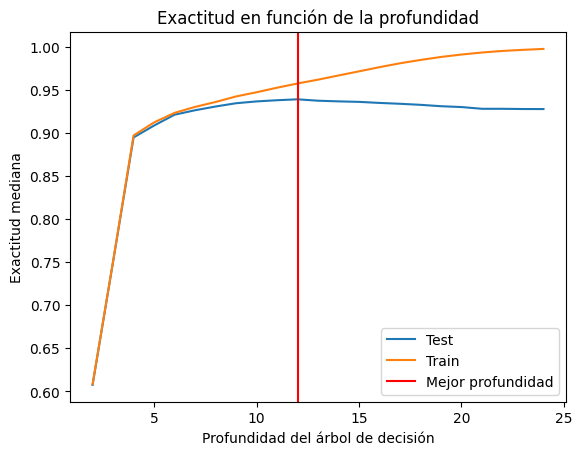

In [29]:
#Grafico promedios
plt.plot(lmd,scoresTest,label="Test")
print(f'El mejor resultado fue con un árbol de profundidad {lmd[np.argmax(scoresTest)]}: {scoresTest[np.argmax(scoresTest)]:.3f}')
plt.plot(lmd,scoresTrain,label="Train")
plt.title("Exactitud en función de la profundidad")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Profundidad del árbol de decisión")
plt.axvline(x=best_prof, label='Mejor profundidad', c='r')
plt.legend()
plt.show()

## Clasificar todos los píxeles de la imágen con los parámetros óptimos encontrados

En la corrida anterior, obtuvimos que la mejor profundidad para nuestros datos de Test fue de 12. Esto en el caso de `DecisionTree` podria variar si la semilla utilizada para instanciar el modelo (`random_state = 42`) fuese distinta. Si nosotros ya conocemos los parámetros del modelo que queremos correr, y lo queremos aplicar a toda la imagen, lo volvemos a definir pasando explícitamente como parámetro el valor `max_depth` que nos devolvió el máximo valor de _accuracy_:

```python
#Entrenemos un arbol de profundidad = best_prod
best_clf_tree = tree.DecisionTreeClassifier(max_depth = best_prof)
best_clf_tree = best_clf_tree.fit(X, Y)
```

In [30]:
#Entrenemos un arbol de profundidad = best_prod
best_clf_tree = tree.DecisionTreeClassifier(max_depth = best_prof)
best_clf_tree = best_clf_tree.fit(X, Y)

Ahora leemos la imagen junto a sus dimensiones (`d,x,y = img.shape`):

```python
#Leo la imágen completa
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape
```

In [31]:
#Leo la imágen completa
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape

Y usamos el modelo definido anteriormente para predecir toda la imagen. Observar que antes de ello, a la imagen debemos darle la estructura de datos que tienen los datos de entrenamiento (X). Eso es lo que hace el comando `img.reshape([d,x*y]).T`: Reordena la matriz para que nos quede un arreglo de dimensiones (bandas, filas x columnas), y luego lo transpone con `.T` para que quede como (filas x columnas, bandas):

```python
#Uso el modelo para clasificar toda la imagen
Y_pred = best_clf_tree.predict(img.reshape([d,x*y]).T)
```

In [32]:
Y_pred = best_clf_tree.predict(img.reshape([d,x*y]).T)

El resultado tiene una sola dimensión (filas x columnas). Si lo quiero re-ordenar como imagen, debo aplicarle un `reshape` nuevamente, pasándole como parámetros las filas y columnas de la imagen original (x e y):

```python
# Reconstruimos el mapa clasificado
class_img = Y_pred.reshape([x, y])

# Lista de etiquetas ordenadas por índice
etiquetas = list(clase_dict.keys())

# Crear un mapa de colores categórico en función de la cantidad de clases
cmap = plt.get_cmap('tab10', len(etiquetas))

plt.figure(figsize=(26, 20), dpi=300)
im = plt.imshow(class_img, cmap=cmap, vmin=0, vmax=len(etiquetas)-1)
cbar = plt.colorbar(im, ticks=np.arange(len(etiquetas)))
cbar.ax.set_yticklabels(etiquetas)
cbar.set_label('Clases', rotation=270, labelpad=15)
plt.title("Mapa de Clasificación", fontsize=20)
plt.axis('off')
plt.show()
```

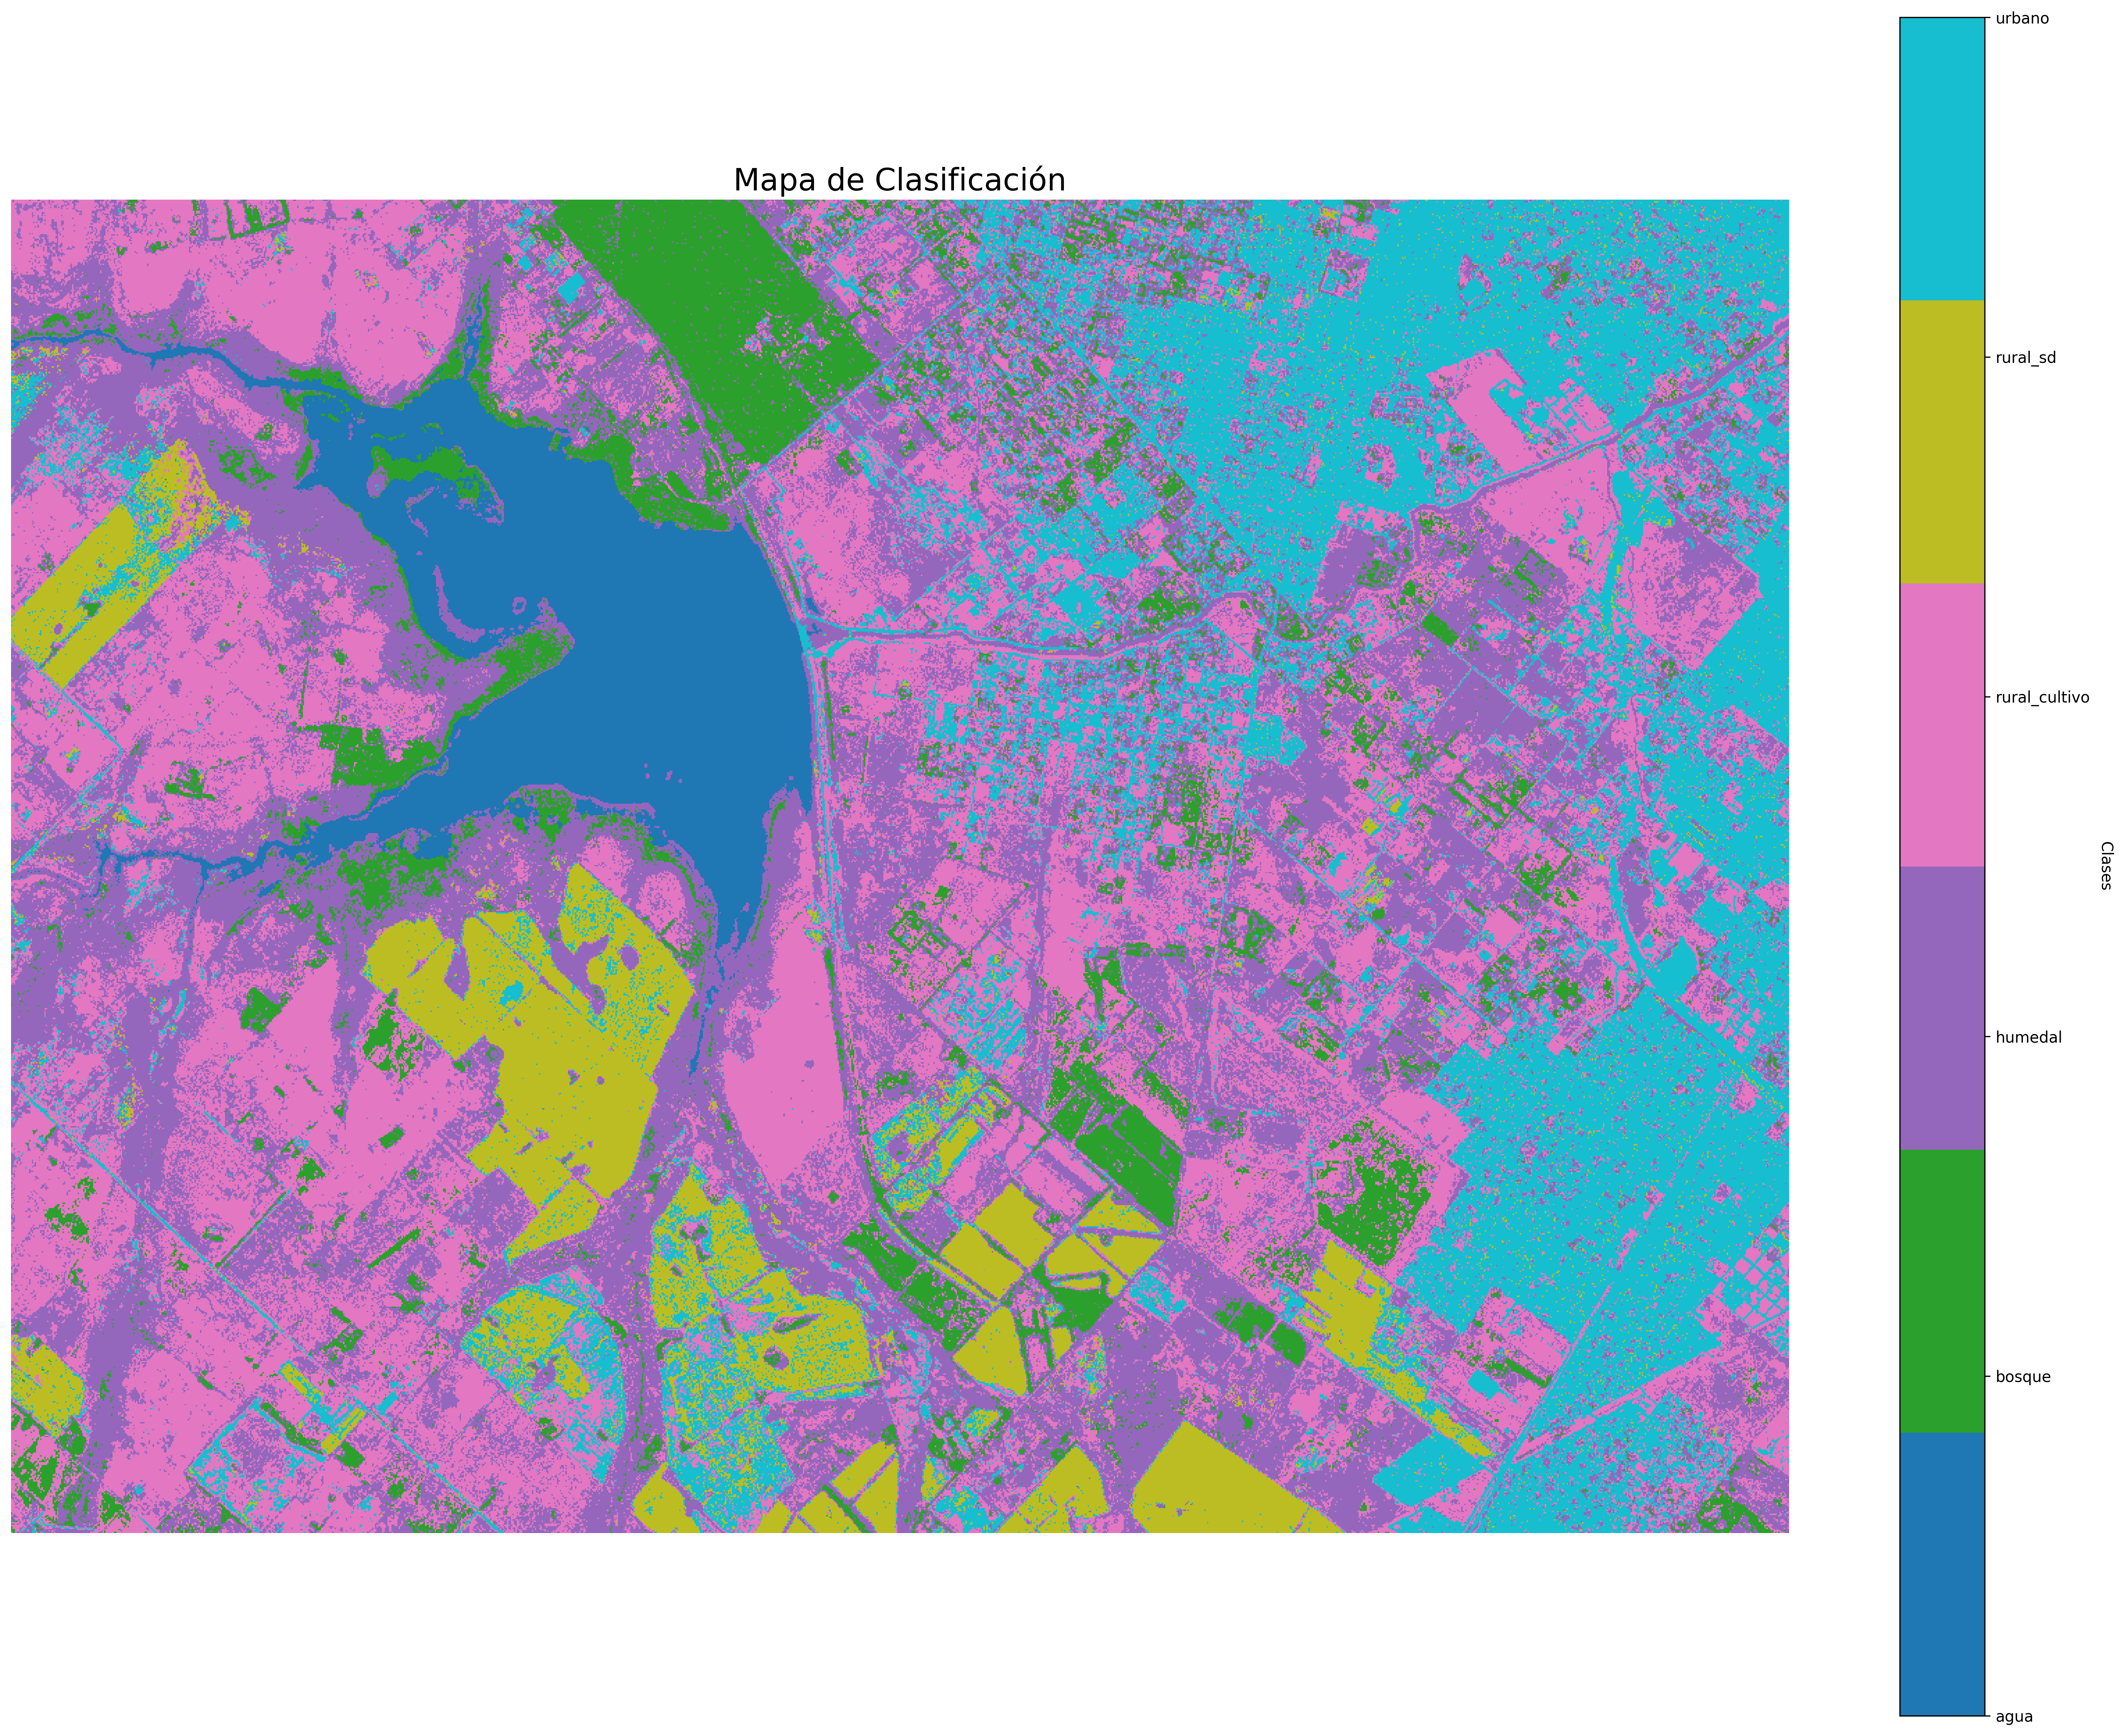

In [33]:
# Reconstruimos el mapa clasificado
class_img = Y_pred.reshape([x, y])

# Lista de etiquetas ordenadas por índice
etiquetas = list(clase_dict.keys())

# Crear un mapa de colores categórico en función de la cantidad de clases
cmap = plt.get_cmap('tab10', len(etiquetas))

plt.figure(figsize=(26, 20), dpi=300)
im = plt.imshow(class_img, cmap=cmap, vmin=0, vmax=len(etiquetas)-1)
cbar = plt.colorbar(im, ticks=np.arange(len(etiquetas)))
cbar.ax.set_yticklabels(etiquetas)
cbar.set_label('Clases', rotation=270, labelpad=15)
plt.title("Mapa de Clasificación", fontsize=20)
plt.axis('off')
plt.show()

Para asegurarme de que los valores de mi clasificación correspondan a las etiquetas de las clases, puedo usar `np.unique()`de Numpy:

```python
np.unique(Y_pred)
```

In [34]:
np.unique(Y_pred)

array([0, 1, 2, 3, 4, 5])

Usando **guardar_GTiff** puedo guardar como raster mi clasificación y mirarla en QGIS. Los parámetros `crs` y `gt` ya los tengo definidos al haber leido la imagen original:

```python
#Guardo un resultado
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + f'Class_IMG_CLF{best_prof}.tif',crs,gt,class_img)
```

In [35]:
#Guardo un resultado
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + f'Class_IMG_CLF{best_prof}.tif',crs,gt,class_img)

### Ejercicio 1.1
Guardá como archivo GeoTiff el mapa generado con KNN, al igual que se hizo con el mapa hecho con DT.

In [36]:
best_clf_knn = KNeighborsClassifier(n_neighbors = 10)
best_clf_knn = best_clf_knn.fit(X, Y)

In [37]:
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape

In [38]:
Y_pred = best_clf_knn.predict(img.reshape([d,x*y]).T)

In [39]:
# Reconstruimos el mapa clasificado
class_img = Y_pred.reshape([x, y])

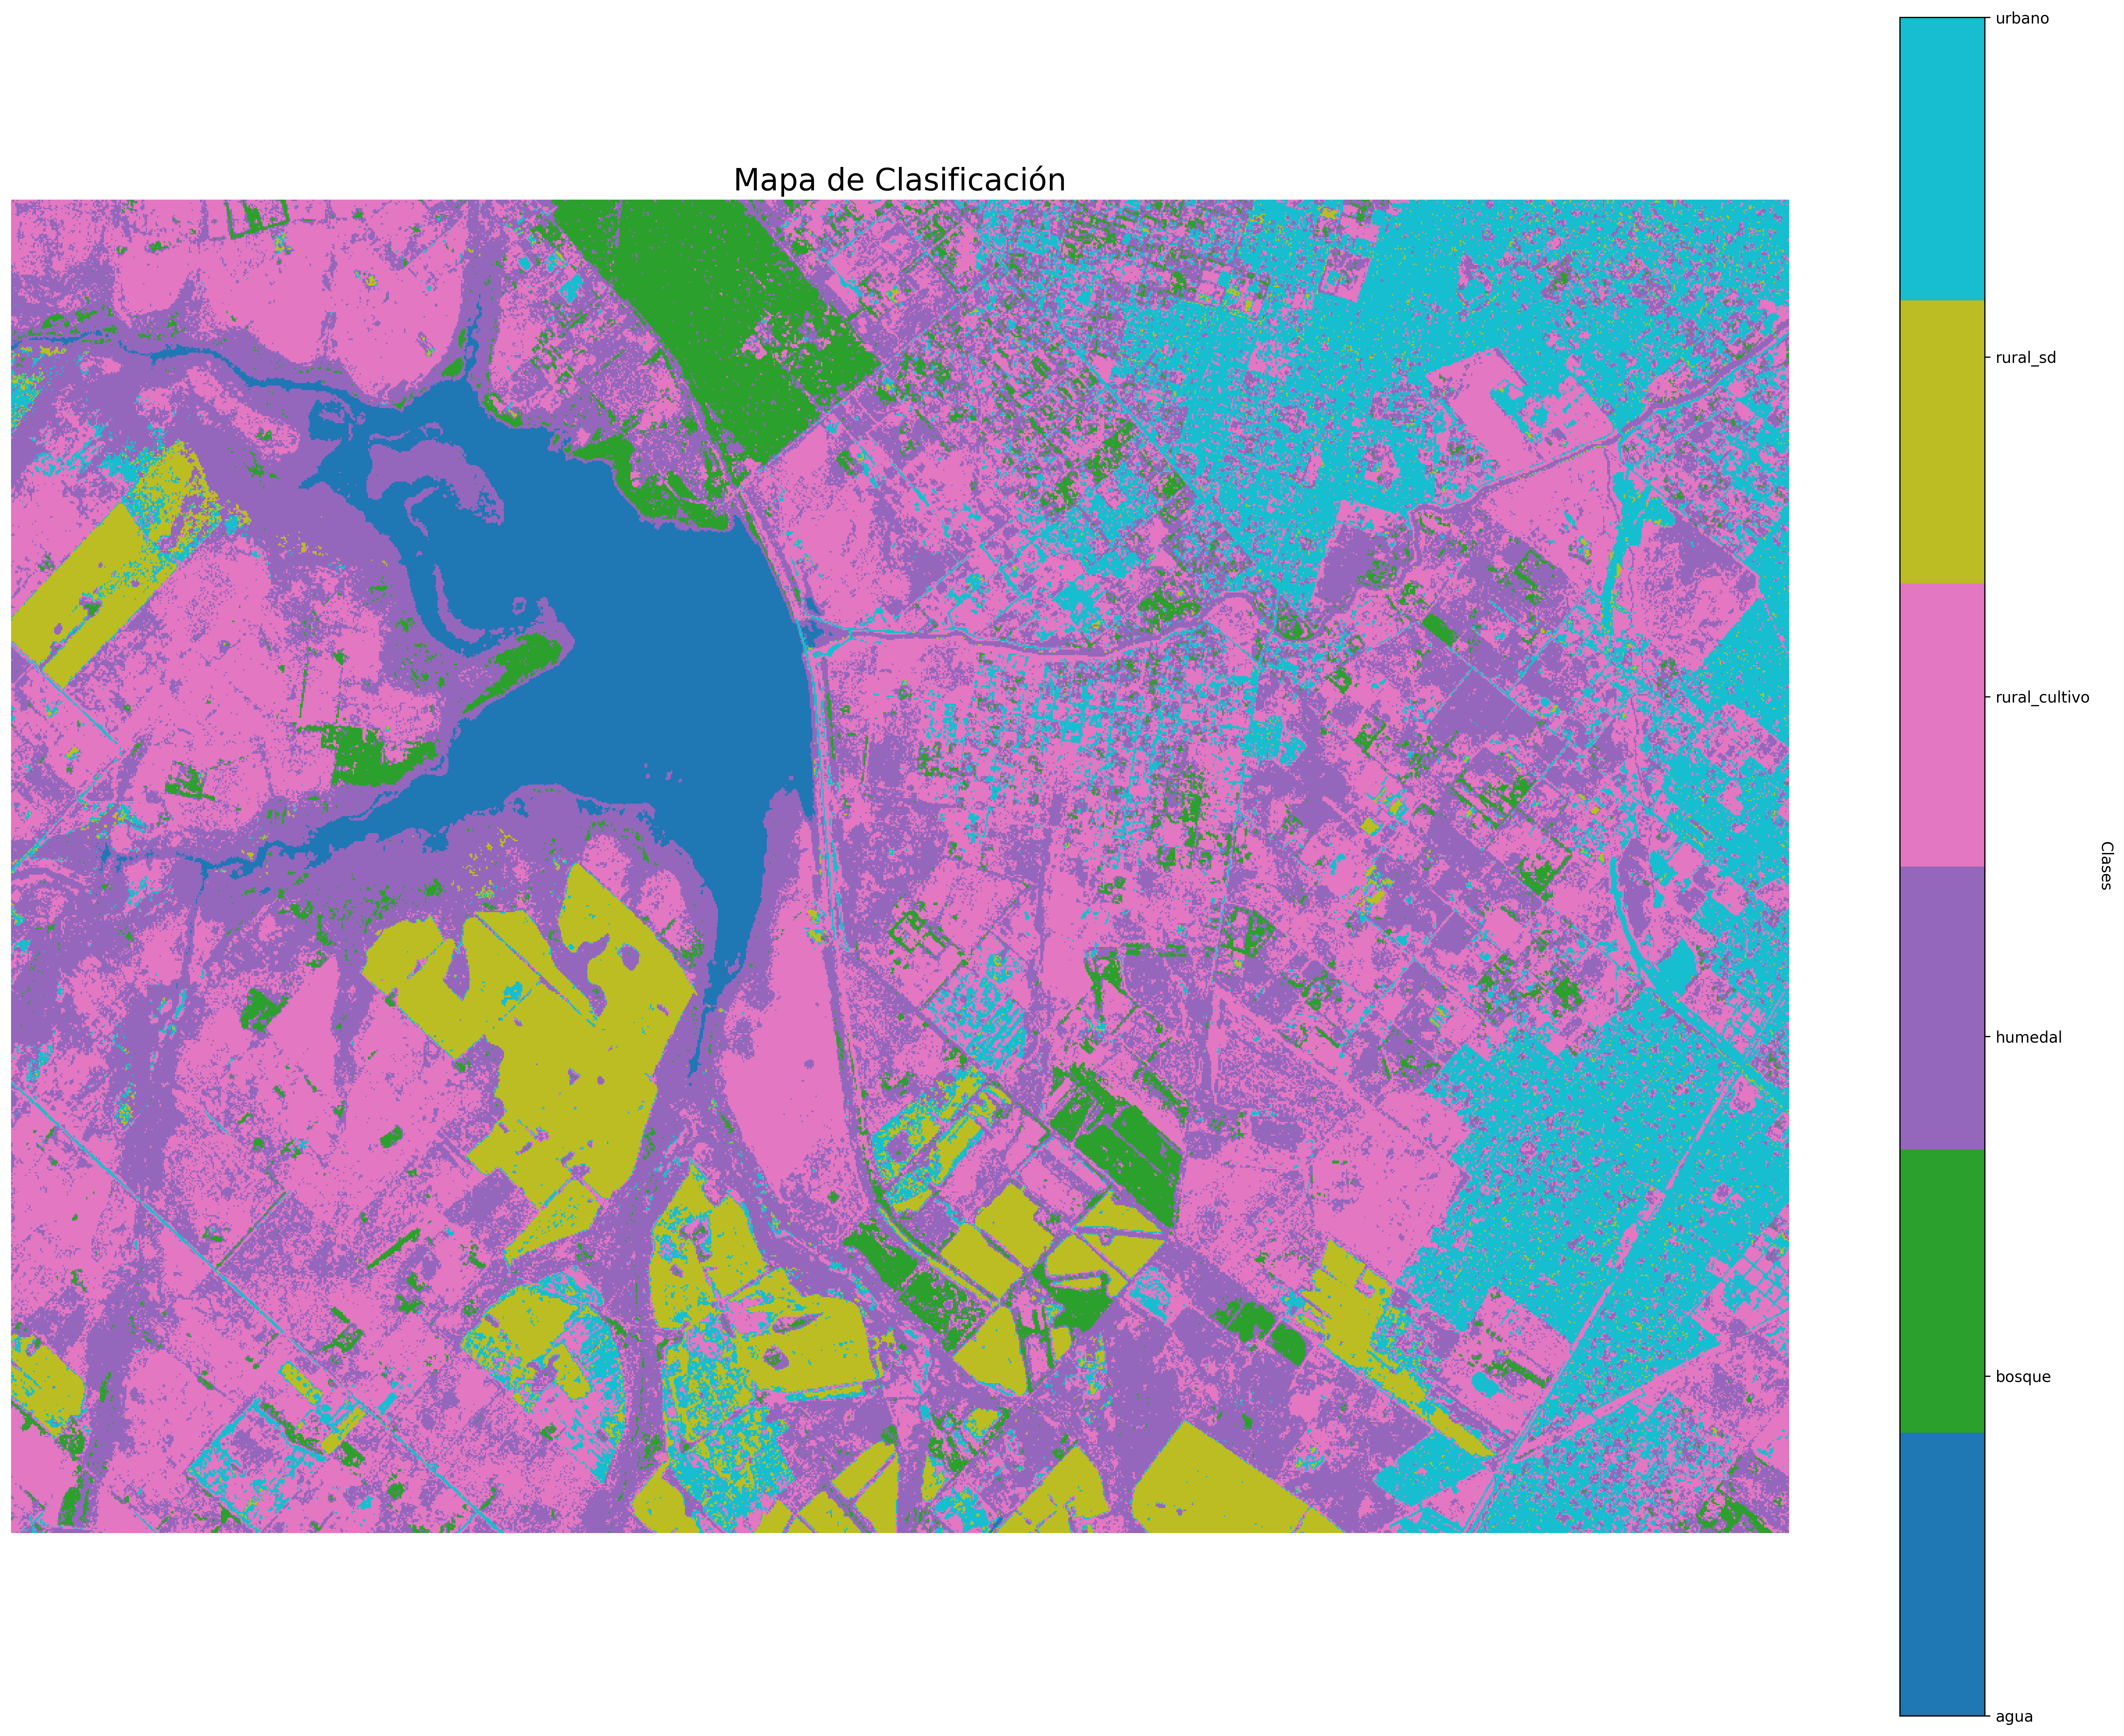

In [40]:
etiquetas = list(clase_dict.keys())

# Crear un mapa de colores categórico en función de la cantidad de clases
cmap = plt.get_cmap('tab10', len(etiquetas))

plt.figure(figsize=(26, 20), dpi=300)
im = plt.imshow(class_img, cmap=cmap, vmin=0, vmax=len(etiquetas)-1)
cbar = plt.colorbar(im, ticks=np.arange(len(etiquetas)))
cbar.ax.set_yticklabels(etiquetas)
cbar.set_label('Clases', rotation=270, labelpad=15)

plt.title("Mapa de Clasificación", fontsize=20)
plt.axis('off')
plt.show()

In [41]:
np.unique(Y_pred)

array([0, 1, 2, 3, 4, 5])

In [42]:
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + f'Class_kNN_IMG_CLF10.tif',crs,gt,class_img)

## Random Forest

Cuando trabajamos con Random Forest, dos de los principales hiper-parámetros del modelo son la profundidad máxima (`max_depth`) y el número de árboles que usamos (`n_estimators`). La forma de construir el clasificador es similar a los otros:

```python
# Entreno un modelo
clf = RandomForestClassifier(n_estimators = 100, max_depth = 12, random_state = 42)
clf.fit(X_train, Y_train)

#lo evaluo
Y_pred = clf.predict(X_test)

# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Accuracy y Kappa
acc = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc:.2f}')

k = kappa(Y_test, Y_pred)
print(f'Índice Kappa: {k:.2f}')
```

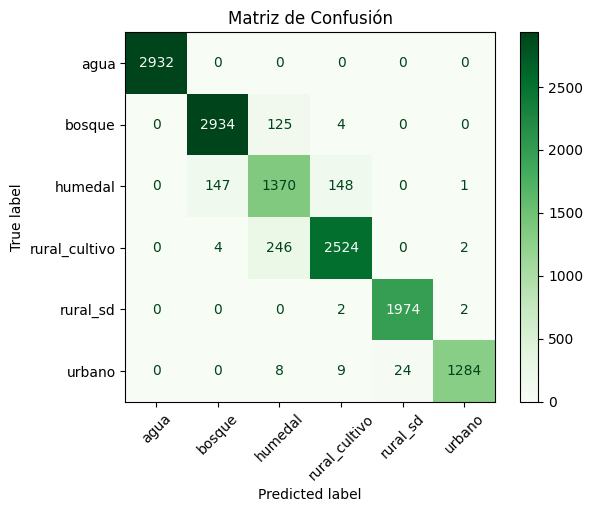

Accuracy: 0.95
Índice Kappa: 0.94


In [43]:
# Entreno un modelo
clf = RandomForestClassifier(n_estimators = 100, max_depth = 12, random_state = 42)
clf.fit(X_train, Y_train)

#lo evaluo
Y_pred = clf.predict(X_test)

# Etiquetas de clase
labels = ['agua', 'bosque', 'humedal', 'rural_cultivo', 'rural_sd', 'urbano']

# Calcular matriz de confusión
M = confusion_matrix(Y_test, Y_pred)

# Visualizar matriz de confusión con etiquetas
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Accuracy y Kappa
acc = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc:.2f}')

k = kappa(Y_test, Y_pred)
print(f'Índice Kappa: {k:.2f}')

Volvemos a repetir el mismo ciclo _for_ que hicimos sobre los árboles de decisión y sobre KNN, pero esta vez buscamos evaluar el impacto de `n_estimators`, asumiendo que entrenamos árboles con profundidad 12. Este proceso será el que más tiempo lleve de todos, ya que en cada iteración se entrenan tantos árboles como cantidad de estimadores que se están evaluando:

```python
valores_estim = [5, 10, 25, 50, 100, 250, 500]
n_estim = len(valores_estim)

resultados_test = np.zeros((n_splits, n_estim))
resultados_train = np.zeros((n_splits, n_estim))

split = 0
for train_index, test_index in skf.split(X, Y):
    print(f'Número de fold: {split}')
    X_train_split, X_test_split = X[train_index, :], X[test_index, :]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]
    
    for j, n in enumerate(valores_estim):
        print(f'Probando con n_estimators = {n} y max_depth = {best_prof}')
        model = RandomForestClassifier(n_estimators=n, max_depth = best_prof, random_state=42)
        model.fit(X_train_split, Y_train_split) 
        Y_pred = model.predict(X_test_split)
        Y_pred_train = model.predict(X_train_split)
        acc_test = metrics.accuracy_score(Y_test_split, Y_pred)
        acc_train = metrics.accuracy_score(Y_train_split, Y_pred_train)
        resultados_test[split, j] = acc_test
        resultados_train[split, j] = acc_train
    
    split += 1
```

In [44]:
valores_estim = [5, 10, 25, 50, 100, 250, 500]
n_estim = len(valores_estim)

resultados_test = np.zeros((n_splits, n_estim))
resultados_train = np.zeros((n_splits, n_estim))

split = 0
for train_index, test_index in skf.split(X, Y):
    print(f'Número de fold: {split}')
    X_train_split, X_test_split = X[train_index, :], X[test_index, :]
    Y_train_split, Y_test_split = Y[train_index], Y[test_index]
    
    for j, n in enumerate(valores_estim):
        print(f'Probando con n_estimators = {n} y max_depth = {best_prof}')
        model = RandomForestClassifier(n_estimators=n, max_depth = best_prof, random_state=42)
        model.fit(X_train_split, Y_train_split) 
        Y_pred = model.predict(X_test_split)
        Y_pred_train = model.predict(X_train_split)
        acc_test = metrics.accuracy_score(Y_test_split, Y_pred)
        acc_train = metrics.accuracy_score(Y_train_split, Y_pred_train)
        resultados_test[split, j] = acc_test
        resultados_train[split, j] = acc_train
    
    split += 1

Número de fold: 0
Probando con n_estimators = 5 y max_depth = 12
Probando con n_estimators = 10 y max_depth = 12
Probando con n_estimators = 25 y max_depth = 12
Probando con n_estimators = 50 y max_depth = 12
Probando con n_estimators = 100 y max_depth = 12
Probando con n_estimators = 250 y max_depth = 12
Probando con n_estimators = 500 y max_depth = 12
Número de fold: 1
Probando con n_estimators = 5 y max_depth = 12
Probando con n_estimators = 10 y max_depth = 12
Probando con n_estimators = 25 y max_depth = 12
Probando con n_estimators = 50 y max_depth = 12
Probando con n_estimators = 100 y max_depth = 12
Probando con n_estimators = 250 y max_depth = 12
Probando con n_estimators = 500 y max_depth = 12
Número de fold: 2
Probando con n_estimators = 5 y max_depth = 12
Probando con n_estimators = 10 y max_depth = 12
Probando con n_estimators = 25 y max_depth = 12
Probando con n_estimators = 50 y max_depth = 12
Probando con n_estimators = 100 y max_depth = 12
Probando con n_estimators = 25

Calculemos los promedios para poder obtener el mejor _accuracy_ medio, de manera similar a como lo hicimos con KNN y DT:

```python
#Calculo promedios de los K folds
scoresTest = resultados_test.mean(axis=0)
scoresTrain = resultados_train.mean(axis=0)

#Busco el mejor resultado
imx = np.argmax(scoresTest)
best_estim = valores_estim[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un Random Forest de profundidad {best_prof}, {best_estim} árboles y una exactitud de {best_acc:.3f}')
```

In [45]:
#Calculo promedios de los K folds
scoresTest = resultados_test.mean(axis=0)
scoresTrain = resultados_train.mean(axis=0)

#Busco el mejor resultado
imx = np.argmax(scoresTest)
best_estim = valores_estim[imx]
best_acc = scoresTest[imx]
print(f'El mejor resultado en el conjunto de testeo fue obtenido para un Random Forest de profundidad {best_prof}, {best_estim} árboles y una exactitud de {best_acc:.3f}')

El mejor resultado en el conjunto de testeo fue obtenido para un Random Forest de profundidad 12, 500 árboles y una exactitud de 0.945


Si graficamos la exactitud en función de la Cantidad de Árboles, veremos cómo se estabilizan ambos a partir de cierta cantidad. Este análisis es útil para entender que no nos hace falta una excesiva cantidad de árboles para lograr buenos resultados:

```python
#Grafico promedios
plt.plot(valores_estim,scoresTest,label="Test")
plt.plot(valores_estim,scoresTrain,label="Train")
plt.title(f"Exactitud en función de la cantidad de árboles, usando max_depth={best_prof}")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Cantidad de árboles (n_estim)")
plt.axvline(x=best_estim, label='Mejor n_estim', c='r')
plt.legend()
plt.show()
```

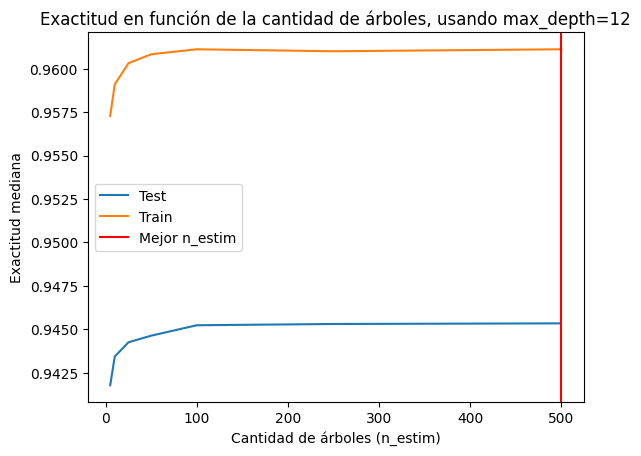

In [46]:
#Grafico promedios
plt.plot(valores_estim,scoresTest,label="Test")
plt.plot(valores_estim,scoresTrain,label="Train")
plt.title(f"Exactitud en función de la cantidad de árboles, usando max_depth={best_prof}")    
plt.ylabel("Exactitud mediana")
plt.xlabel("Cantidad de árboles (n_estim)")
plt.axvline(x=best_estim, label='Mejor n_estim', c='r')
plt.legend()
plt.show()

### Ejercicio 1.2

a) Guardá como archivo GeoTiff el mapa generado con RF, al igual que se hizo con el mapa hecho con DT y con KNN.

b) Entrená un clasificador con alguno de los 3 algoritmos vistos en esta clase, usando como entrada una imagen del 2019 (disponible en este [enlace](https://drive.google.com/file/d/1hA2Bda1iGGC7Z8lOzF6QzmxbV12RGKOz/view?usp=sharing)), y un archivo GEOJSON con muestras vectoriales adaptadas a esas fechas, disponible en este [enlace](https://drive.google.com/file/d/18rr1oPGh7X8rX3YUisHLeqXl2SBGy2xI/view?usp=sharing). Clasificá toda la imagen y guardala como archivo GeoTiff. Las clases definidas en estas muestras son las mismas que usamos en los ejemplos de esta Notebook con la imagen de 2018.

Para agilizar la primera parte que tiene que ver con la extracción de muestras, te dejamos esta función que lee la imagen, el GeoDataFrame vectorial con las muestras y un valor de nodato para usar en el enmascarado, y devuelve los arreglos _X_, _Y_ y el diccionario de clases que relaciona cada clase con su número. Opcionalmente deja indicar cuáles son las columnas para leer la clase y la geometría:

```python
def extraer_muestras(raster_fn, rois_shp, nodata_val, clase_col='clase', geometry_col='geometry'):
    clases = list(set(rois_shp[clase_col]))
    clases.sort() #numero las clases de los ROIs alfabéticamente
    clase_dict = {clase:i for i, clase in enumerate(clases)}

    X = np.empty((0, 0))
    Y = np.array([])

    with rasterio.open(raster_fn) as src:
        for index, row in rois_shp.iterrows():
            poli = row[geometry_col]
            clase = row[clase_col]
            #Realizo la máscara usando poli como geometria
            clip, _transform = mask(src, [poli], crop=True,nodata=nodata)
            #Calculo las dimensiones del recorte (d siempre va a ser igual, numero de bandas)
            d,x,y = clip.shape
            # Reacomodo todo como si fuera una tabla (reshape), y con .T lo traspongo. Eso me da la 
            #misma estructura de X
            D = list(clip.reshape([d,x*y]).T)
            #Con esta línea me aseguro de eliminar cualquier valor NoData producto del enmascarado. Usamos .prod() para
            # garantizar que en nunguna dimensión (banda) haya quedado un valor sin datos
            D = [p for p in D if (not (p==nodata).prod())]
            # Convierto a la tabla/lista D en array
            DX = np.array(D)
            #Genero la lista de etiquetas (número) que corresponden a esta clase (lo saco del diccionario definido previamente)
            DY = np.repeat(clase_dict[clase],len(D))
            #a X le concateno DX
            if X.shape[1:] == (0,) or X.size == 0:
                X = DX
            else:
                X = np.concatenate((X,DX))
            #a Y le concateno DY
            Y = np.concatenate((Y,DY))
    
    return X, Y, clase_dict


# Ejemplo de uso
raster_fn = path_proc + 'S2_dique_20191120.tif'
rois_shp = gpd.read_file(path_shp+'rois_dique3_2019.geojson')

X_2019,Y_2019,clase_dict_2019 = extraer_muestras(raster_fn, rois_shp, nodata_val = -255, clase_col='clase', geometry_col='geometry')
```

In [47]:
#1.2 A
best_clf_rf = RandomForestClassifier(n_estimators= 100, max_depth=12, random_state=42)
best_clf_rf = best_clf_rf.fit(X, Y)

In [48]:
#Leo la imágen completa
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape

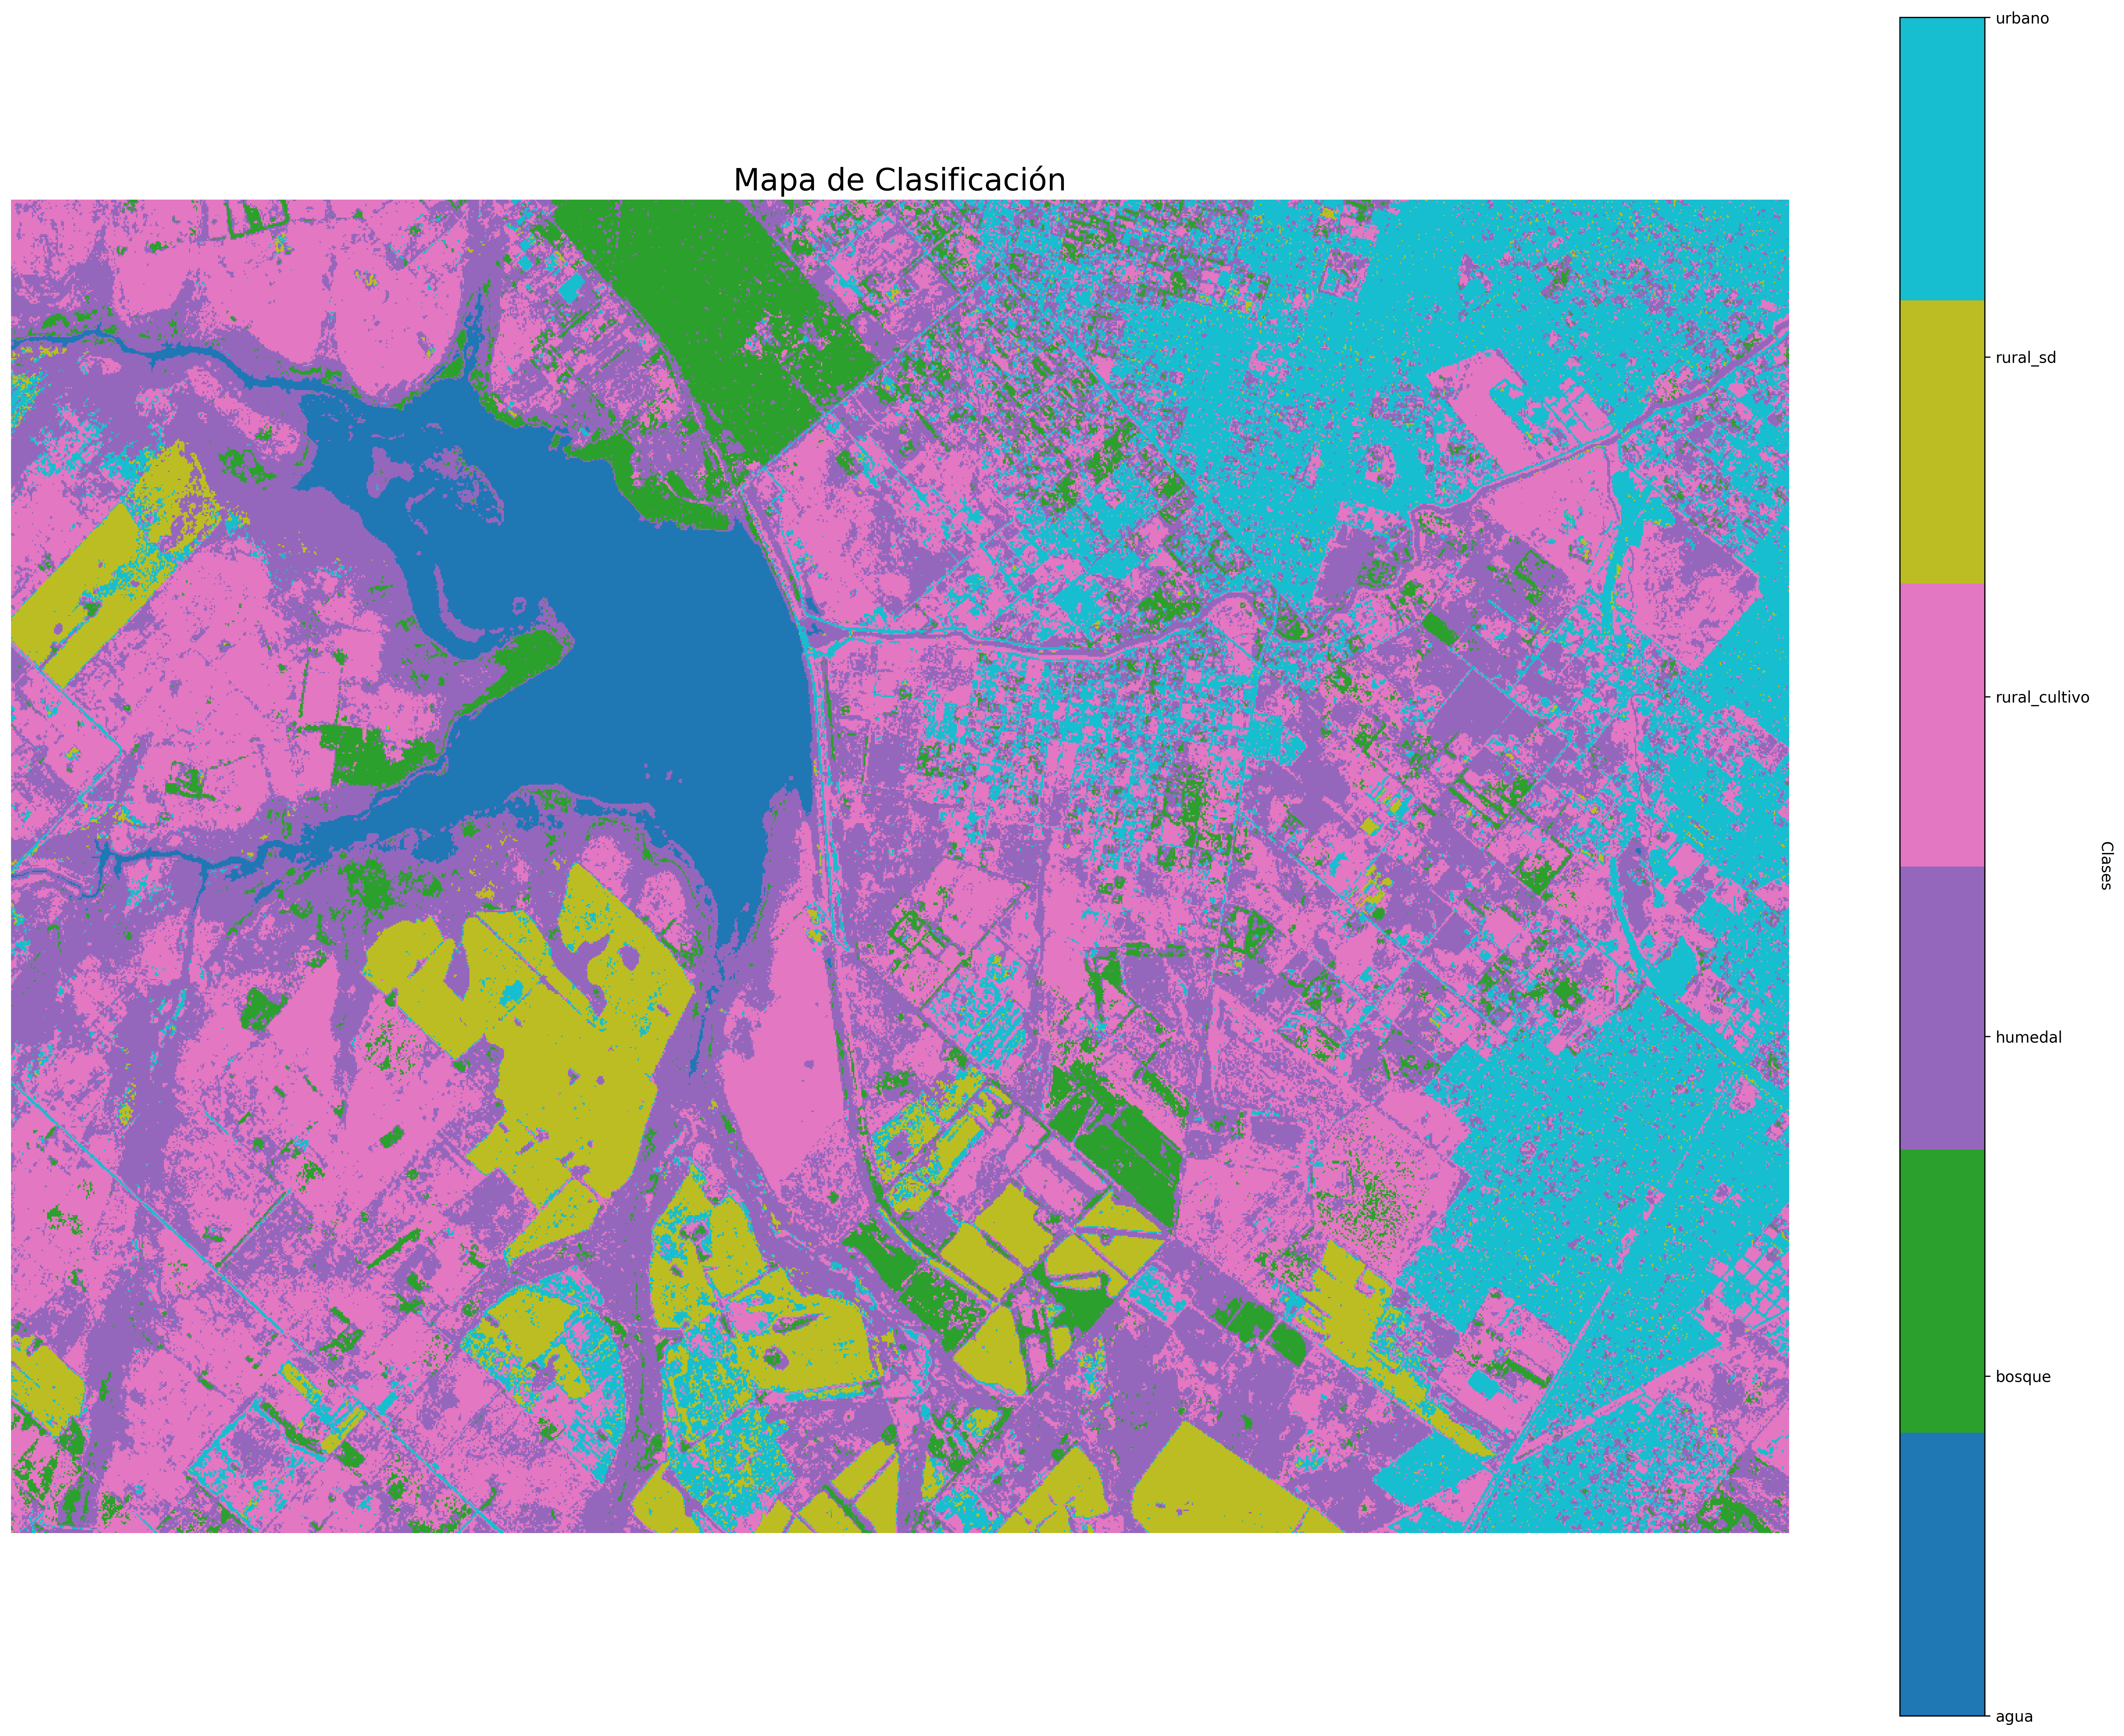

In [49]:
Y_pred = best_clf_rf.predict(img.reshape([d,x*y]).T)

class_img = Y_pred.reshape([x, y])

etiquetas = list(clase_dict.keys())

cmap = plt.get_cmap('tab10', len(etiquetas))

plt.figure(figsize=(26, 20), dpi=300)
im = plt.imshow(class_img, cmap=cmap, vmin=0, vmax=len(etiquetas)-1)
cbar = plt.colorbar(im, ticks=np.arange(len(etiquetas)))
cbar.ax.set_yticklabels(etiquetas)
cbar.set_label('Clases', rotation=270, labelpad=15)


plt.title("Mapa de Clasificación", fontsize=20)
plt.axis('off')
plt.show()

In [50]:
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + f'Class_RF_IMG_CLF100.tif',crs,gt,class_img)

In [58]:
def extraer_muestras(raster_fn, rois_shp, nodata_val, clase_col='clase', geometry_col='geometry'):
    
    if isinstance(rois_shp, str):
        rois_shp = gpd.read_file(rois_shp)

    clases = sorted(set(rois_shp[clase_col]))
    clase_dict = {clase: i for i, clase in enumerate(clases)}

    X = np.empty((0, 0))
    Y = np.array([])

    with rasterio.open(raster_fn) as src:
        for index, row in rois_shp.iterrows():
            poli = row[geometry_col]
            clase = row[clase_col]

            try:
                clip, _ = mask(src, [poli], crop=True, nodata=nodata_val)
            except:
                continue

            d, x, y = clip.shape
            D = clip.reshape((d, x * y)).T
            D = D[~np.any(D == nodata_val, axis=1)]  # Filtrar pixeles con algún valor nodata

            if D.shape[0] == 0:
                continue  

            DX = np.array(D)
            DY = np.repeat(clase_dict[clase], DX.shape[0])

            if X.shape[1:] == (0,) or X.size == 0:
                X = DX
            else:
                X = np.concatenate((X, DX))

            Y = np.concatenate((Y, DY))

    return X, Y.astype(int), clase_dict


# Ejemplo de uso
raster_fn = './raw_data/tp7/S2_dique_20191120.tif'
rois_path = './raw_data/tp7/rois_dique3_2019.geojson'

X_2019, Y_2019, clase_dict_2019 = extraer_muestras(
    raster_fn=raster_fn,
    rois_shp=rois_path,
    nodata_val=-255,
    clase_col='clase',
    geometry_col='geometry'
)

print("Shape X:", X_2019.shape)
print("Shape Y:", Y_2019.shape)
print("Diccionario de clases:", clase_dict_2019)

Shape X: (45596, 5)
Shape Y: (45596,)
Diccionario de clases: {'agua': 0, 'bosque': 1, 'humedal': 2, 'rural_cultivo': 3, 'rural_sd': 4, 'urbano': 5}


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import pandas as pd


X_train, X_test, Y_train, Y_test = train_test_split(
    X_2019, Y_2019,
    test_size=0.25,
    stratify=Y_2019,
    random_state=42
)


rf = RandomForestClassifier(random_state=42, n_jobs=-1)


param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
}

# La literatura dice que 10 veces la validación cruzada suele ser aceptable
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)


grid_search.fit(X_train, Y_train)

print("Mejor score en CV (accuracy):", grid_search.best_score_)
print("Mejores hiperparámetros:")
print(grid_search.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Mejor score en CV (accuracy): 0.9758751490210364
Mejores hiperparámetros:
{'max_depth': None, 'n_estimators': 200}


In [67]:
# Mejor modelo encontrado
mejor_rf = grid_search.best_estimator_

In [68]:
# Predecir en set de test
Y_pred = mejor_rf.predict(X_test)

In [70]:
target_names = [k for k, v in sorted(clase_dict_2019.items(), key=lambda item: item[1])]

# Reporte de clasificación
print("\n Reporte en conjunto de TEST:")
print(classification_report(Y_test, Y_pred, target_names=target_names))


 Reporte en conjunto de TEST:
               precision    recall  f1-score   support

         agua       1.00      1.00      1.00      2883
       bosque       0.99      0.99      0.99      3108
      humedal       0.92      0.91      0.92      1293
rural_cultivo       0.91      0.92      0.91       786
     rural_sd       0.98      0.99      0.99      1971
       urbano       0.99      0.98      0.98      1358

     accuracy                           0.98     11399
    macro avg       0.97      0.97      0.97     11399
 weighted avg       0.98      0.98      0.98     11399



In [71]:
best_clf_rf2 = RandomForestClassifier(n_estimators= 200, max_depth=None, random_state=42)
best_clf_rf2 = best_clf_rf2.fit(X, Y)

raster_fn = './raw_data/tp7/S2_dique_20191120.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    crs = src.crs
    gt = src.transform
img.shape
d,x,y = img.shape

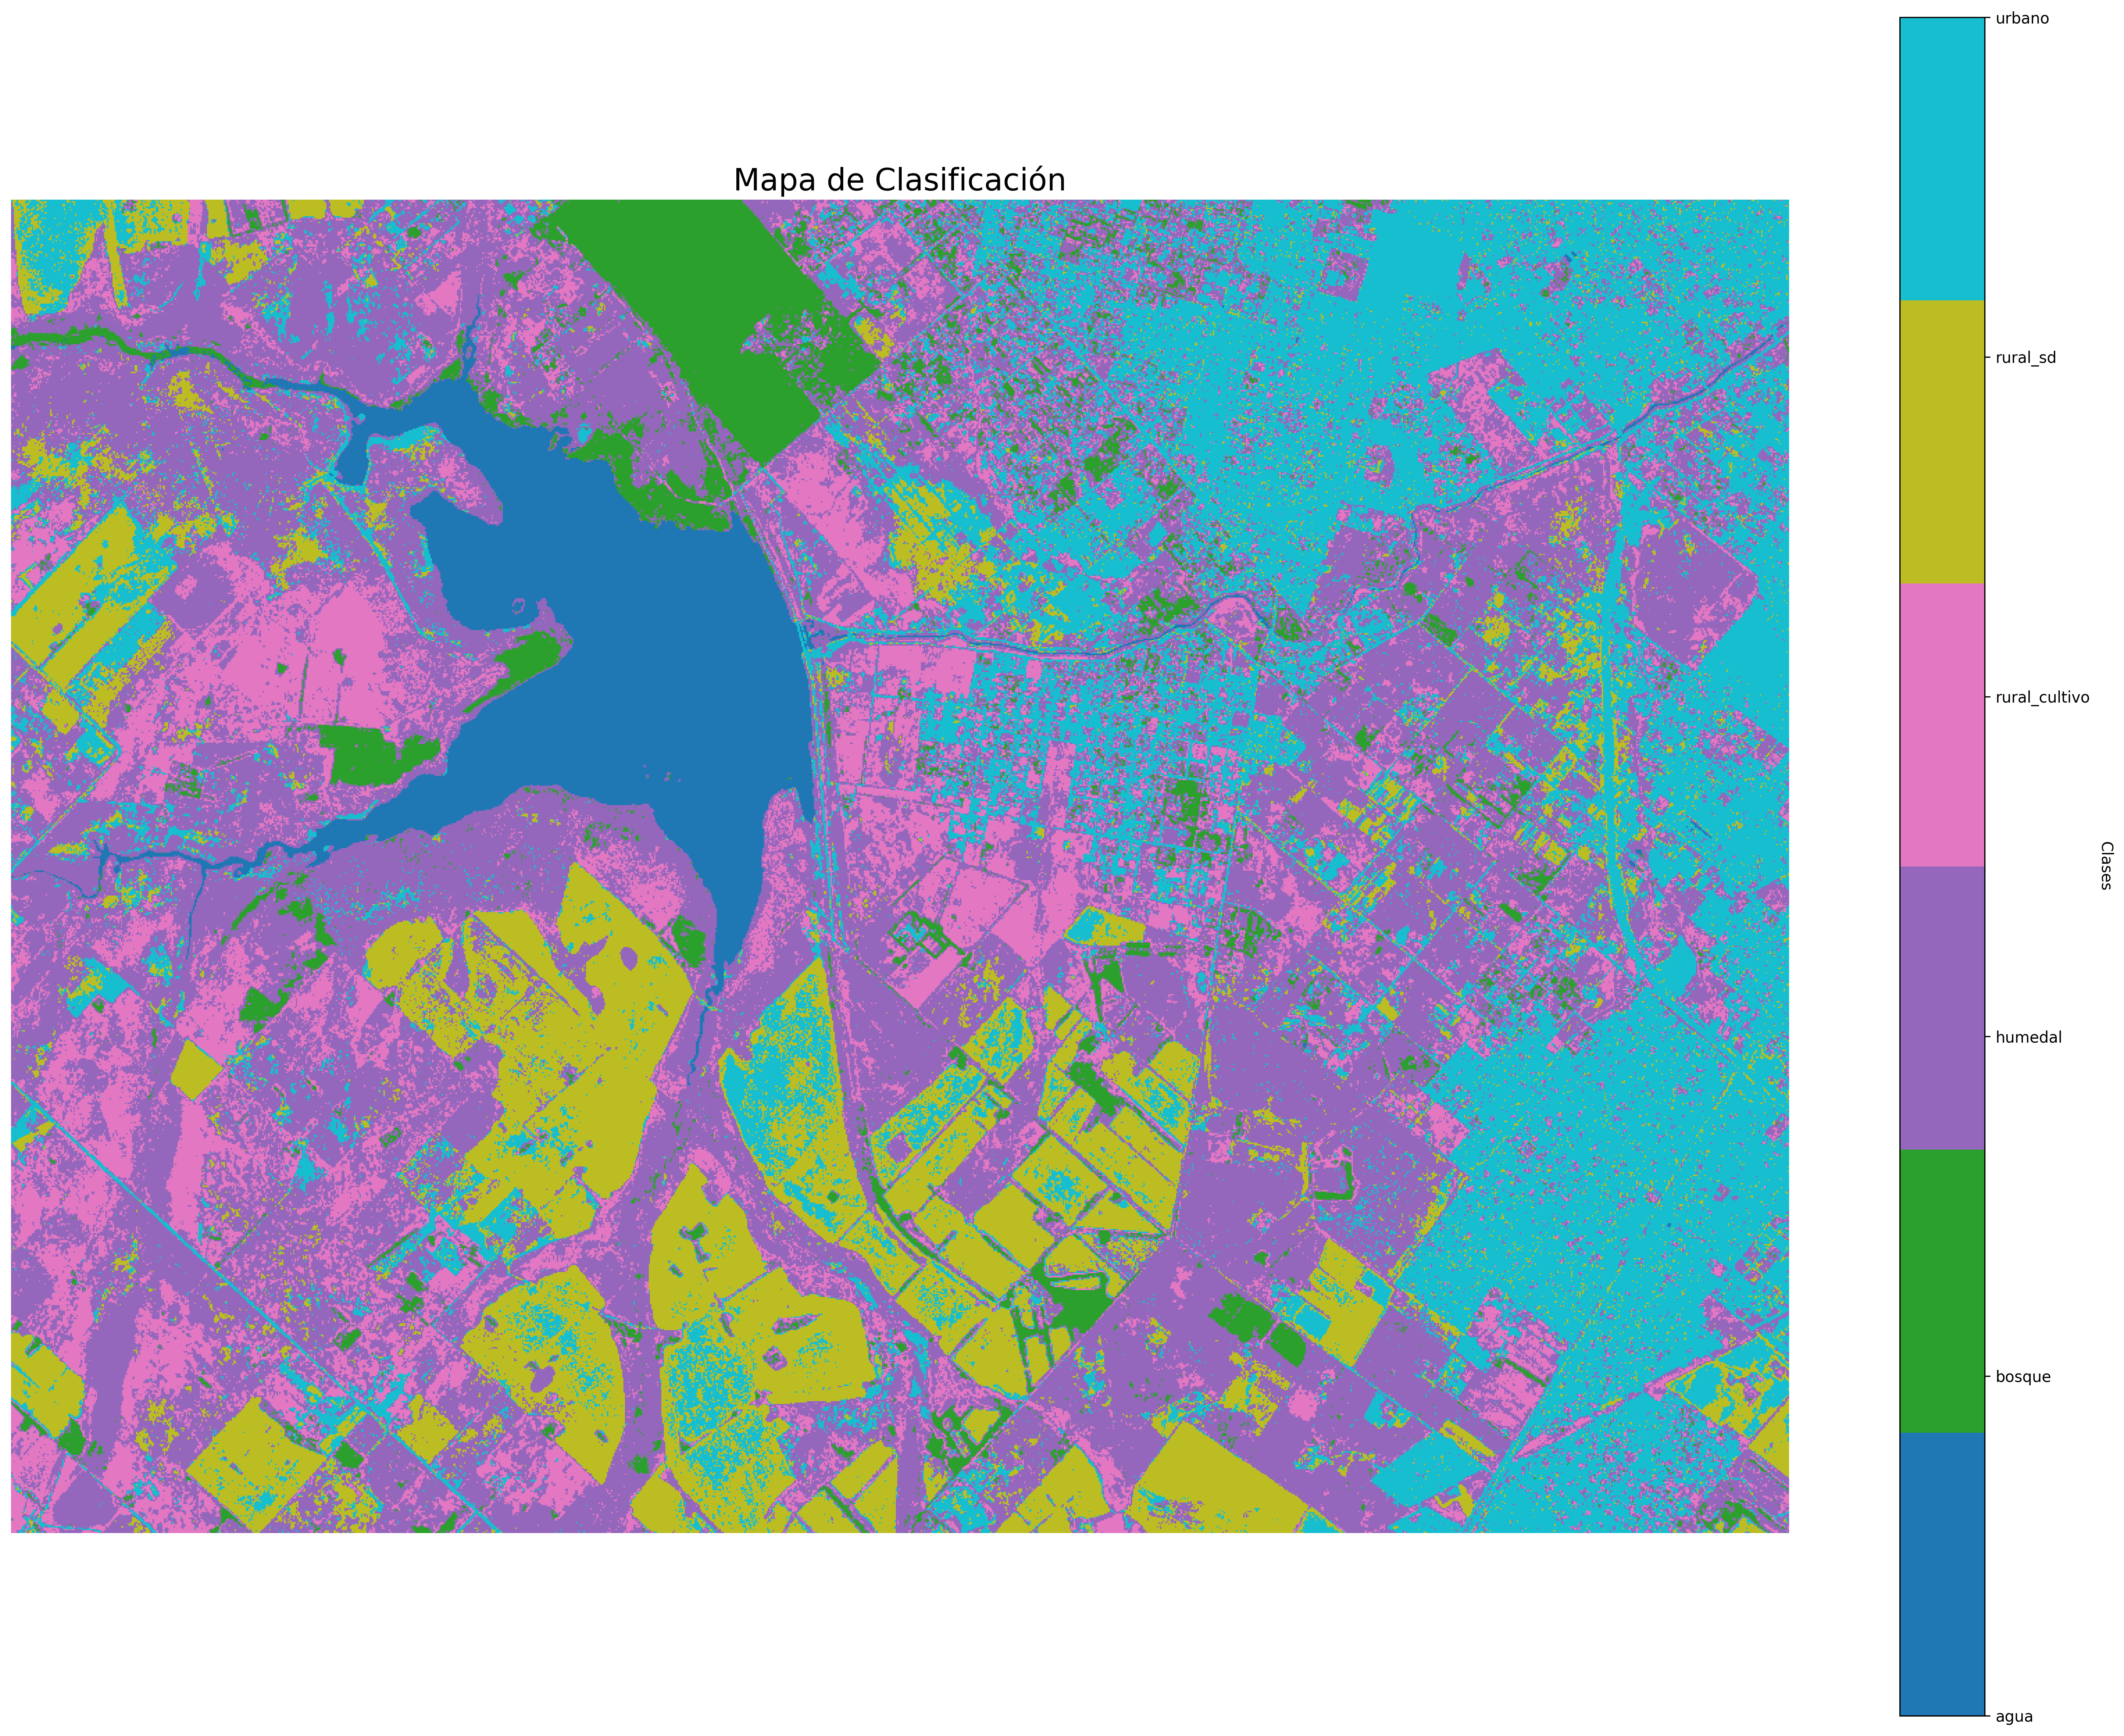

In [73]:
Y_pred = best_clf_rf2.predict(img.reshape([d,x*y]).T)

if isinstance(Y_pred[0], str):
    Y_pred = np.vectorize(clase_dict.get)(Y_pred)  

class_img = Y_pred.reshape([x, y])

etiquetas = list(clase_dict.keys())
cmap = plt.get_cmap('tab10', len(etiquetas))

# 5. Graficamos
plt.figure(figsize=(26, 20), dpi=300)
im = plt.imshow(class_img, cmap=cmap, vmin=0, vmax=len(etiquetas)-1)
cbar = plt.colorbar(im, ticks=np.arange(len(etiquetas)))
cbar.ax.set_yticklabels(etiquetas)
cbar.set_label('Clases', rotation=270, labelpad=15)

plt.title("Mapa de Clasificación", fontsize=20)
plt.axis('off')
plt.show()

In [74]:
class_img = Y_pred.reshape([x,y])
guardar_GTiff(path_out + f'Class_rf_IMG_CLF200.tif',crs,gt,class_img)

### Ejercicio 1.3 (Opcional)

Si te quedan ganas de seguir jugando con las clasificaciones, generá (en QGIS, o donde te sea más cómodo) tu propio archivo vectorial con muestras usando la imagen de 2018 de esta Notebook, o la imagen de 2019 del ejercicio 1.2. Usalas como datos para entrenar y evaluar un clasificador. Podés hacer una búsqueda de hiper-parámetros, o simplemente llamarlo con valores definidos por vos.